# Handoffs
Handoff is a multi-agent design pattern introduced by OpenAI in an experimental project called Swarm. The key idea is to let agent delegate tasks to other agents using a special tool call.

We can use the AutoGen Core API to implement the handoff pattern using event-driven agents. Using AutoGen (v0.4+) provides the following advantages over the OpenAI implementation and the previous version (v0.2):

It can scale to distributed environment by using distributed agent runtime.

It affords the flexibility of bringing your own agent implementation.

The natively async API makes it easy to integrate with UI and other systems.

This notebook demonstrates a simple implementation of the handoff pattern. It is recommended to read Topics and Subscriptions to understand the basic concepts of pub-sub and event-driven agents

This scenario is modified based on the OpenAI example.

Consider a customer service scenario where a customer is trying to get a refund for a product, or purchase a new product from a chatbot. The chatbot is a multi-agent team consisting of three AI agents and one human agent:

Triage Agent, responsible for understanding the customer’s request and deciding which other agents to hand off to.

Refund Agent, responsible for processing refund requests.

Sales Agent, responsible for processing sales requests.

Human Agent, responsible for handling complex requests that the AI agents can’t handle.

In this scenario, the customer interacts with the chatbot through a User Agent.

The diagram below shows the interaction topology of the agents in this scenario.

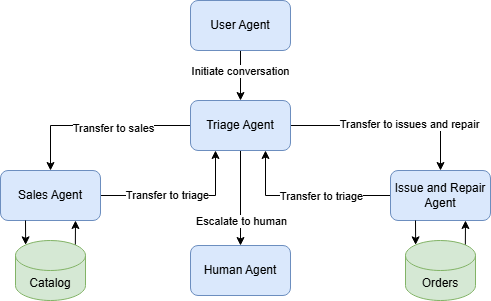


In [ ]:
import json
import uuid
from typing import List, Tuple

from autogen_core import (
    FunctionCall,
    MessageContext,
    RoutedAgent,
    SingleThreadedAgentRuntime,
    TopicId,
    TypeSubscription,
    message_handler,
)
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    FunctionExecutionResult,
    FunctionExecutionResultMessage,
    LLMMessage,
    SystemMessage,
    UserMessage,
)
from autogen_core.tools import FunctionTool, Tool
from autogen_ext.models.openai import OpenAIChatCompletionClient
from pydantic import BaseModel

# Message Protocol
Before everything, we need to define the message protocol for the agents to communicate. We are using event-driven pub-sub communication, so these message types will be used as events.

UserLogin is a message published by the runtime when a user logs in and starts a new session.

UserTask is a message containing the chat history of the user session. When an AI agent hands off a task to other agents, it also publishes a UserTask message.

AgentResponse is a message published by the AI agents and the Human Agent, it also contains the chat history as well as a topic type for the customer to reply to.

In [ ]:
class UserLogin(BaseModel):
    pass


class UserTask(BaseModel):
    context: List[LLMMessage]


class AgentResponse(BaseModel):
    reply_to_topic_type: str
    context: List[LLMMessage]

# AI Agent
We start with the AIAgent class, which is the class for all AI agents (i.e., Triage, Sales, and Issue and Repair Agents) in the multi-agent chatbot. An AIAgent uses a ChatCompletionClient to generate responses. It can use regular tools directly or delegate tasks to other agents using delegate_tools. It subscribes to topic type agent_topic_type to receive messages from the customer, and sends message to the customer by publishing to the topic type user_topic_type.

In the handle_task method, the agent first generates a response using the model. If the response contains a handoff tool call, the agent delegates the task to another agent by publishing a UserTask message to the topic specified in the tool call result. If the response is a regular tool call, the agent executes the tool and makes another call to the model to generate the next response, until the response is not a tool call.

When the model response is not a tool call, the agent sends an AgentResponse message to the customer by publishing to the user_topic_type.

In [ ]:
class AIAgent(RoutedAgent):
    def __init__(
        self,
        description: str,
        system_message: SystemMessage,
        model_client: ChatCompletionClient,
        tools: List[Tool],
        delegate_tools: List[Tool],
        agent_topic_type: str,
        user_topic_type: str,
    ) -> None:
        super().__init__(description)
        self._system_message = system_message
        self._model_client = model_client
        self._tools = dict([(tool.name, tool) for tool in tools])
        self._tool_schema = [tool.schema for tool in tools]
        self._delegate_tools = dict([(tool.name, tool) for tool in delegate_tools])
        self._delegate_tool_schema = [tool.schema for tool in delegate_tools]
        self._agent_topic_type = agent_topic_type
        self._user_topic_type = user_topic_type

    @message_handler
    async def handle_task(self, message: UserTask, ctx: MessageContext) -> None:
        # Send the task to the LLM.
        llm_result = await self._model_client.create(
            messages=[self._system_message] + message.context,
            tools=self._tool_schema + self._delegate_tool_schema,
            cancellation_token=ctx.cancellation_token,
        )
        print(f"{'-'*80}\n{self.id.type}:\n{llm_result.content}", flush=True)
        # Process the LLM result.
        while isinstance(llm_result.content, list) and all(isinstance(m, FunctionCall) for m in llm_result.content):
            tool_call_results: List[FunctionExecutionResult] = []
            delegate_targets: List[Tuple[str, UserTask]] = []
            # Process each function call.
            for call in llm_result.content:
                arguments = json.loads(call.arguments)
                if call.name in self._tools:
                    # Execute the tool directly.
                    result = await self._tools[call.name].run_json(arguments, ctx.cancellation_token)
                    result_as_str = self._tools[call.name].return_value_as_string(result)
                    tool_call_results.append(
                        FunctionExecutionResult(call_id=call.id, content=result_as_str, is_error=False, name=call.name)
                    )
                elif call.name in self._delegate_tools:
                    # Execute the tool to get the delegate agent's topic type.
                    result = await self._delegate_tools[call.name].run_json(arguments, ctx.cancellation_token)
                    topic_type = self._delegate_tools[call.name].return_value_as_string(result)
                    # Create the context for the delegate agent, including the function call and the result.
                    delegate_messages = list(message.context) + [
                        AssistantMessage(content=[call], source=self.id.type),
                        FunctionExecutionResultMessage(
                            content=[
                                FunctionExecutionResult(
                                    call_id=call.id,
                                    content=f"Transferred to {topic_type}. Adopt persona immediately.",
                                    is_error=False,
                                    name=call.name,
                                )
                            ]
                        ),
                    ]
                    delegate_targets.append((topic_type, UserTask(context=delegate_messages)))
                else:
                    raise ValueError(f"Unknown tool: {call.name}")
            if len(delegate_targets) > 0:
                # Delegate the task to other agents by publishing messages to the corresponding topics.
                for topic_type, task in delegate_targets:
                    print(f"{'-'*80}\n{self.id.type}:\nDelegating to {topic_type}", flush=True)
                    await self.publish_message(task, topic_id=TopicId(topic_type, source=self.id.key))
            if len(tool_call_results) > 0:
                print(f"{'-'*80}\n{self.id.type}:\n{tool_call_results}", flush=True)
                # Make another LLM call with the results.
                message.context.extend(
                    [
                        AssistantMessage(content=llm_result.content, source=self.id.type),
                        FunctionExecutionResultMessage(content=tool_call_results),
                    ]
                )
                llm_result = await self._model_client.create(
                    messages=[self._system_message] + message.context,
                    tools=self._tool_schema + self._delegate_tool_schema,
                    cancellation_token=ctx.cancellation_token,
                )
                print(f"{'-'*80}\n{self.id.type}:\n{llm_result.content}", flush=True)
            else:
                # The task has been delegated, so we are done.
                return
        # The task has been completed, publish the final result.
        assert isinstance(llm_result.content, str)
        message.context.append(AssistantMessage(content=llm_result.content, source=self.id.type))
        await self.publish_message(
            AgentResponse(context=message.context, reply_to_topic_type=self._agent_topic_type),
            topic_id=TopicId(self._user_topic_type, source=self.id.key),
        )

# Human Agent
The HumanAgent class is a proxy for the human in the chatbot. It is used to handle requests that the AI agents can’t handle. The HumanAgent subscribes to the topic type agent_topic_type to receive messages and publishes to the topic type user_topic_type to send messages to the customer.

In this implementation, the HumanAgent simply uses console to get your input. In a real-world application, you can improve this design as follows:

In the handle_user_task method, send a notification via a chat application like Teams or Slack.

The chat application publishes the human’s response via the runtime to the topic specified by agent_topic_type

Create another message handler to process the human’s response and send it back to the customer.

In [ ]:
class HumanAgent(RoutedAgent):
    def __init__(self, description: str, agent_topic_type: str, user_topic_type: str) -> None:
        super().__init__(description)
        self._agent_topic_type = agent_topic_type
        self._user_topic_type = user_topic_type

    @message_handler
    async def handle_user_task(self, message: UserTask, ctx: MessageContext) -> None:
        human_input = input("Human agent input: ")
        print(f"{'-'*80}\n{self.id.type}:\n{human_input}", flush=True)
        message.context.append(AssistantMessage(content=human_input, source=self.id.type))
        await self.publish_message(
            AgentResponse(context=message.context, reply_to_topic_type=self._agent_topic_type),
            topic_id=TopicId(self._user_topic_type, source=self.id.key),
        )

# User Agent
The UserAgent class is a proxy for the customer that talks to the chatbot. It handles two message types: UserLogin and AgentResponse. When the UserAgent receives a UserLogin message, it starts a new session with the chatbot and publishes a UserTask message to the AI agent that subscribes to the topic type agent_topic_type. When the UserAgent receives an AgentResponse message, it prompts the user with the response from the chatbot.

In this implementation, the UserAgent uses console to get your input. In a real-world application, you can improve the human interaction using the same idea described in the HumanAgent section above.

In [ ]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, user_topic_type: str, agent_topic_type: str) -> None:
        super().__init__(description)
        self._user_topic_type = user_topic_type
        self._agent_topic_type = agent_topic_type

    @message_handler
    async def handle_user_login(self, message: UserLogin, ctx: MessageContext) -> None:
        print(f"{'-'*80}\nUser login, session ID: {self.id.key}.", flush=True)
        # Get the user's initial input after login.
        user_input = input("User: ")
        print(f"{'-'*80}\n{self.id.type}:\n{user_input}")
        await self.publish_message(
            UserTask(context=[UserMessage(content=user_input, source="User")]),
            topic_id=TopicId(self._agent_topic_type, source=self.id.key),
        )

    @message_handler
    async def handle_task_result(self, message: AgentResponse, ctx: MessageContext) -> None:
        # Get the user's input after receiving a response from an agent.
        user_input = input("User (type 'exit' to close the session): ")
        print(f"{'-'*80}\n{self.id.type}:\n{user_input}", flush=True)
        if user_input.strip().lower() == "exit":
            print(f"{'-'*80}\nUser session ended, session ID: {self.id.key}.")
            return
        message.context.append(UserMessage(content=user_input, source="User"))
        await self.publish_message(
            UserTask(context=message.context), topic_id=TopicId(message.reply_to_topic_type, source=self.id.key)
        )

# Tools for the AI agents
The AI agents can use regular tools to complete tasks if they don’t need to hand off the task to other agents. We define the tools using simple functions and create the tools using the FunctionTool wrapper.

In [ ]:
def execute_order(product: str, price: int) -> str:
    print("\n\n=== Order Summary ===")
    print(f"Product: {product}")
    print(f"Price: ${price}")
    print("=================\n")
    confirm = input("Confirm order? y/n: ").strip().lower()
    if confirm == "y":
        print("Order execution successful!")
        return "Success"
    else:
        print("Order cancelled!")
        return "User cancelled order."


def look_up_item(search_query: str) -> str:
    item_id = "item_132612938"
    print("Found item:", item_id)
    return item_id


def execute_refund(item_id: str, reason: str = "not provided") -> str:
    print("\n\n=== Refund Summary ===")
    print(f"Item ID: {item_id}")
    print(f"Reason: {reason}")
    print("=================\n")
    print("Refund execution successful!")
    return "success"


execute_order_tool = FunctionTool(execute_order, description="Price should be in USD.")
look_up_item_tool = FunctionTool(
    look_up_item, description="Use to find item ID.\nSearch query can be a description or keywords."
)
execute_refund_tool = FunctionTool(execute_refund, description="")

# Topic types for the agents
We define the topic types each of the agents will subscribe to. Read more about topic types in the[Topics and Subscriptions](https://microsoft.github.io/autogen/stable//user-guide/core-user-guide/core-concepts/topic-and-subscription.html)

In [ ]:
sales_agent_topic_type = "SalesAgent"
issues_and_repairs_agent_topic_type = "IssuesAndRepairsAgent"
triage_agent_topic_type = "TriageAgent"
human_agent_topic_type = "HumanAgent"
user_topic_type = "User"

# Delegate tools for the AI agents
Besides regular tools, the AI agents can delegate tasks to other agents using special tools called delegate tools. The concept of delegate tool is only used in this design pattern, and the delegate tools are also defined as simple functions. We differentiate the delegate tools from regular tools in this design pattern because when an AI agent calls a delegate tool, we transfer the task to another agent instead of continue generating responses using the model in the same agent.

In [ ]:
def transfer_to_sales_agent() -> str:
    return sales_agent_topic_type


def transfer_to_issues_and_repairs() -> str:
    return issues_and_repairs_agent_topic_type


def transfer_back_to_triage() -> str:
    return triage_agent_topic_type


def escalate_to_human() -> str:
    return human_agent_topic_type


transfer_to_sales_agent_tool = FunctionTool(
    transfer_to_sales_agent, description="Use for anything sales or buying related."
)
transfer_to_issues_and_repairs_tool = FunctionTool(
    transfer_to_issues_and_repairs, description="Use for issues, repairs, or refunds."
)
transfer_back_to_triage_tool = FunctionTool(
    transfer_back_to_triage,
    description="Call this if the user brings up a topic outside of your purview,\nincluding escalating to human.",
)
escalate_to_human_tool = FunctionTool(escalate_to_human, description="Only call this if explicitly asked to.")


# Creating the team
We have defined the AI agents, the Human Agent, the User Agent, the tools, and the topic types. Now we can create the team of agents.

For the AI agents, we use the OpenAIChatCompletionClient and gpt-4o-mini model.

After creating the agent runtime, we register each of the agent by providing an agent type and a factory method to create agent instance. The runtime is responsible for managing the agent lifecycle so we don’t need to instantiate the agents ourselves. Read more about agent runtime in Agent Runtime Environments and agent lifecycle in Agent Identity and Lifecycle.

In the code below, you can see we are using AIAgent class to define the Triage, Sales, and Issue and Repair Agents. We added regular tools and delegate tools to each of them. We also added subscriptions to the topic types for each of the agents.

In [ ]:
runtime = SingleThreadedAgentRuntime()

model_client = OpenAIChatCompletionClient(
    model="gpt-4o-mini",
    # api_key="YOUR_API_KEY",
)

# Register the triage agent.
triage_agent_type = await AIAgent.register(
    runtime,
    type=triage_agent_topic_type,  # Using the topic type as the agent type.
    factory=lambda: AIAgent(
        description="A triage agent.",
        system_message=SystemMessage(
            content="You are a customer service bot for ACME Inc. "
            "Introduce yourself. Always be very brief. "
            "Gather information to direct the customer to the right department. "
            "But make your questions subtle and natural."
        ),
        model_client=model_client,
        tools=[],
        delegate_tools=[
            transfer_to_issues_and_repairs_tool,
            transfer_to_sales_agent_tool,
            escalate_to_human_tool,
        ],
        agent_topic_type=triage_agent_topic_type,
        user_topic_type=user_topic_type,
    ),
)
# Add subscriptions for the triage agent: it will receive messages published to its own topic only.
await runtime.add_subscription(TypeSubscription(topic_type=triage_agent_topic_type, agent_type=triage_agent_type.type))

# Register the sales agent.
sales_agent_type = await AIAgent.register(
    runtime,
    type=sales_agent_topic_type,  # Using the topic type as the agent type.
    factory=lambda: AIAgent(
        description="A sales agent.",
        system_message=SystemMessage(
            content="You are a sales agent for ACME Inc."
            "Always answer in a sentence or less."
            "Follow the following routine with the user:"
            "1. Ask them about any problems in their life related to catching roadrunners.\n"
            "2. Casually mention one of ACME's crazy made-up products can help.\n"
            " - Don't mention price.\n"
            "3. Once the user is bought in, drop a ridiculous price.\n"
            "4. Only after everything, and if the user says yes, "
            "tell them a crazy caveat and execute their order.\n"
            ""
        ),
        model_client=model_client,
        tools=[execute_order_tool],
        delegate_tools=[transfer_back_to_triage_tool],
        agent_topic_type=sales_agent_topic_type,
        user_topic_type=user_topic_type,
    ),
)
# Add subscriptions for the sales agent: it will receive messages published to its own topic only.
await runtime.add_subscription(TypeSubscription(topic_type=sales_agent_topic_type, agent_type=sales_agent_type.type))

# Register the issues and repairs agent.
issues_and_repairs_agent_type = await AIAgent.register(
    runtime,
    type=issues_and_repairs_agent_topic_type,  # Using the topic type as the agent type.
    factory=lambda: AIAgent(
        description="An issues and repairs agent.",
        system_message=SystemMessage(
            content="You are a customer support agent for ACME Inc."
            "Always answer in a sentence or less."
            "Follow the following routine with the user:"
            "1. First, ask probing questions and understand the user's problem deeper.\n"
            " - unless the user has already provided a reason.\n"
            "2. Propose a fix (make one up).\n"
            "3. ONLY if not satisfied, offer a refund.\n"
            "4. If accepted, search for the ID and then execute refund."
        ),
        model_client=model_client,
        tools=[
            execute_refund_tool,
            look_up_item_tool,
        ],
        delegate_tools=[transfer_back_to_triage_tool],
        agent_topic_type=issues_and_repairs_agent_topic_type,
        user_topic_type=user_topic_type,
    ),
)
# Add subscriptions for the issues and repairs agent: it will receive messages published to its own topic only.
await runtime.add_subscription(
    TypeSubscription(topic_type=issues_and_repairs_agent_topic_type, agent_type=issues_and_repairs_agent_type.type)
)

# Register the human agent.
human_agent_type = await HumanAgent.register(
    runtime,
    type=human_agent_topic_type,  # Using the topic type as the agent type.
    factory=lambda: HumanAgent(
        description="A human agent.",
        agent_topic_type=human_agent_topic_type,
        user_topic_type=user_topic_type,
    ),
)
# Add subscriptions for the human agent: it will receive messages published to its own topic only.
await runtime.add_subscription(TypeSubscription(topic_type=human_agent_topic_type, agent_type=human_agent_type.type))

# Register the user agent.
user_agent_type = await UserAgent.register(
    runtime,
    type=user_topic_type,
    factory=lambda: UserAgent(
        description="A user agent.",
        user_topic_type=user_topic_type,
        agent_topic_type=triage_agent_topic_type,  # Start with the triage agent.
    ),
)
# Add subscriptions for the user agent: it will receive messages published to its own topic only.
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))


# Running the team
Finally, we can start the runtime and simulate a user session by publishing a UserLogin message to the runtime. The message is published to the topic ID with type set to user_topic_type and source set to a unique session_id. This session_id will be used to create all topic IDs in this user session and will also be used to create the agent ID for all the agents in this user session. To read more about how topic ID and agent ID are created, read Agent Identity and Lifecycle. and Topics and Subscriptions.

In [ ]:
# Start the runtime.
runtime.start()

# Create a new session for the user.
session_id = str(uuid.uuid4())
await runtime.publish_message(UserLogin(), topic_id=TopicId(user_topic_type, source=session_id))

# Run until completion.
await runtime.stop_when_idle()